In [1]:
from helpers import load_csv_data, create_csv_submission
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from common import batch_iter, sigmoid
from mie import build_k_indices, cross_validation, logistic_loss, train_val_split, subsample_class
from performance import accuracy, f1_score

Load data

In [2]:
x_train_norm = np.load("processed/x_train.npy")
x_test_norm = np.load("processed/x_test.npy")
y_train = np.load("processed/y_train.npy")
test_ids = np.load("processed/test_ids.npy")
train_ids = np.load("processed/train_ids.npy")

Logistic regression

In [3]:
# Split fissa: per valutare performance
X_train, y_train, X_val, y_val = train_val_split(x_train_norm, y_train, val_ratio=0.2)

# Subsampling only on training set
#X_bal, y_bal = subsample_class(X_train, y_train, target_ratio=0.3)


Cross validation

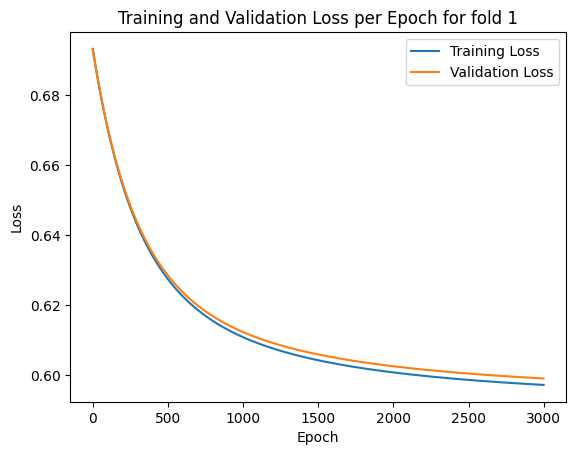

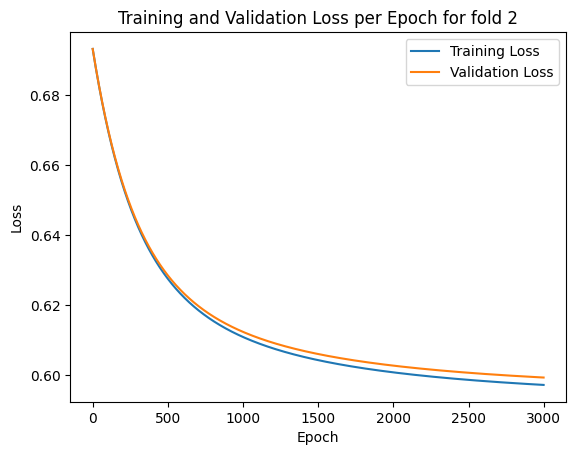

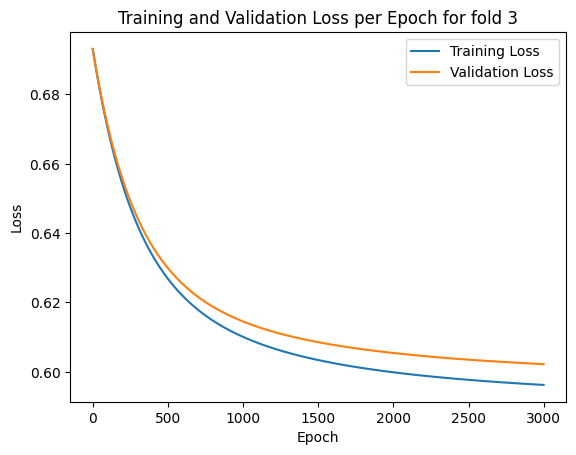

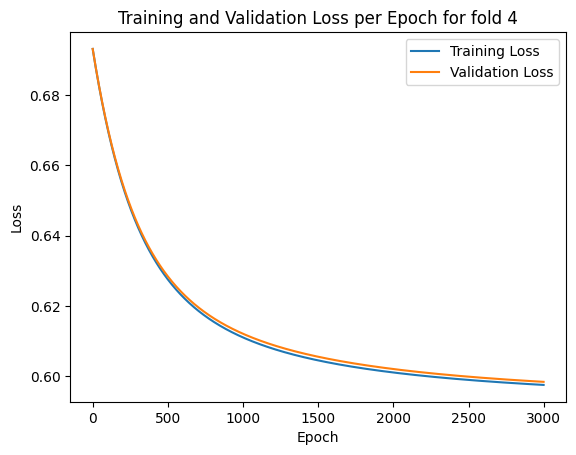

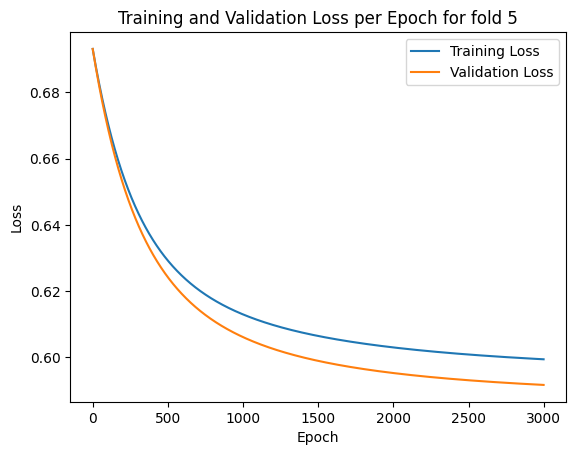

Accuracy:  0.5526846580254254
F1:  0.14905316401630814


In [4]:
k_fold=5
k_indices=build_k_indices(y_train, k_fold, seed=42)
loss_val=[]
loss_tr=[]
ws=[]
acc_scores=[]
f1_scores=[]
initial_w = np.zeros((X_train.shape[1], 1))

for k in range(k_fold):
    w, loss_tr_tmp, loss_val_tmp = cross_validation(y_train, X_train, k_indices, k, initial_w, max_iters=3000, gamma=0.001, lambda_=0.1)
    loss_tr.append(loss_tr_tmp[-1])
    loss_val.append(loss_val_tmp[-1])
    ws.append(w)

    plt.plot(loss_tr_tmp, label='Training Loss')
    plt.plot(loss_val_tmp, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(f'Training and Validation Loss per Epoch for fold {k+1}')
    plt.legend()
    plt.show()
   
w_best=np.mean(ws, axis=0)

y_pred_prob = sigmoid(X_val @ w)
y_pred = np.where(y_pred_prob >= 0.5, 1, -1)
acc = accuracy(y_val, y_pred)
f1 = f1_score(y_val, y_pred)
acc_scores.append(acc)
f1_scores.append(f1)
print("Accuracy: ", acc)
print("F1: ", f1)


Test

In [5]:
y_pred_prob = sigmoid(x_test_norm @ w_best)
y_pred = np.where(y_pred_prob >= 0.5, 1, -1)

create_csv_submission(test_ids, y_pred, 'Reg_Logistic_1')